<a href="https://colab.research.google.com/github/skyshine460/Datascience_notebook/blob/%E7%89%B9%E5%BE%B4%E9%87%8F%E3%82%A8%E3%83%B3%E3%82%B8%E3%83%8B%E3%82%A2%E3%83%AA%E3%83%B3%E3%82%B0%EF%BC%91/%E5%BC%95%E3%81%A3%E8%B6%8A%E3%81%97%E4%BA%88%E6%B8%ACbaseline_ipynb2_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリのインポート

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# 初期設定
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# データの読み込み

In [25]:
df_train = pd.read_csv('/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/train.csv')
pd.set_option('display.max_columns', None)
df_train.head()

,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17,0,0,-1,-1
1,2010-07-02,18,0,0,-1,-1
2,2010-07-03,20,0,0,-1,-1
3,2010-07-04,20,0,0,-1,-1
4,2010-07-05,14,0,0,-1,-1


# パターン識別

In [26]:
# 各カラムのデータ型と欠損値（nan）を表示
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    return info_df

print(df_train.shape)
information_df(df_train)

(2101, 6)


,dtypes,NaN Count,Nunique,Unique Values
datetime,object,0,2101,"[2010-07-01, 2010-07-02, 2010-07-03, 2010-07-0..."
y,int64,0,99,"[17, 18, 20, 14, 4, 10, 12, 21, 15, 11, 8, 13,..."
client,int64,0,2,"[0, 1]"
close,int64,0,2,"[0, 1]"
price_am,int64,0,7,"[-1, 0, 1, 2, 3, 5, 4]"
price_pm,int64,0,7,"[-1, 0, 1, 2, 3, 4, 5]"


In [27]:
# datetimeを年月日に分ける
df_train["year"] = df_train["datetime"].str.split("-", expand=True)[0].astype(np.int64)
df_train["month"] = df_train["datetime"].str.split("-", expand=True)[1].astype(np.int64)
df_train["day"] = df_train["datetime"].str.split("-", expand=True)[2].astype(np.int64)

df_train.head()

,datetime,y,client,close,price_am,price_pm,year,month,day
0,2010-07-01,17,0,0,-1,-1,2010,7,1
1,2010-07-02,18,0,0,-1,-1,2010,7,2
2,2010-07-03,20,0,0,-1,-1,2010,7,3
3,2010-07-04,20,0,0,-1,-1,2010,7,4
4,2010-07-05,14,0,0,-1,-1,2010,7,5


In [28]:
df_train2 = df_train.drop(["datetime", "client", "close", "price_am", "price_pm", "day"], axis=1)

df_train2["month"] = df_train2["month"].astype(str).str.zfill(2)
df_train2["year_month"] = df_train2["year"].astype(str) + df_train2["month"]

df_train2 = df_train2.drop(["year", "month"], axis=1)
df_train2.head()

,y,year_month
0,17,201007
1,18,201007
2,20,201007
3,20,201007
4,14,201007


In [29]:
df = df_train2.groupby("year_month")["y"].sum().reset_index()
df

,year_month,y
0,201007,480
1,201008,512
2,201009,494
3,201010,425
4,201011,493
5,201012,595
6,201101,420
7,201102,560
8,201103,935
9,201104,710


In [30]:
df.shape

(69, 2)

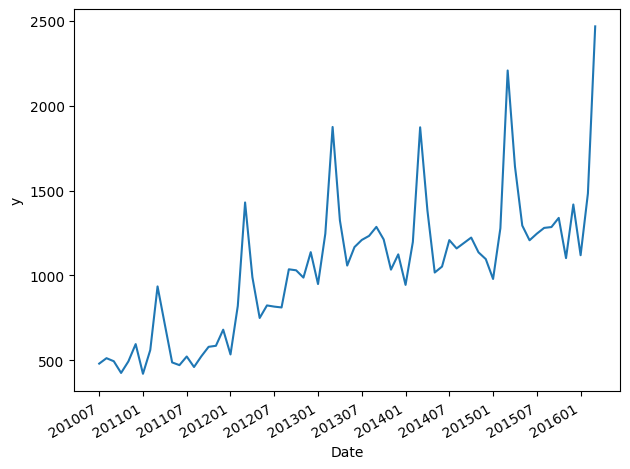

In [39]:
# グラフ描画
fig, ax = plt.subplots()

ax.plot(df['year_month'], df['y'])
ax.set_xlabel('Date')
ax.set_ylabel('y')

plt.xticks(
    np.arange(0, 69, 6),  # 目盛りの位置: 0から69まで6刻み
    ["201007", "201101", "201107", "201201", "201207", "201301", "201307", "201401", "201407", "201501", "201507", "201601"]  # ラベル: 合計13個
)

fig.autofmt_xdate()
plt.tight_layout()

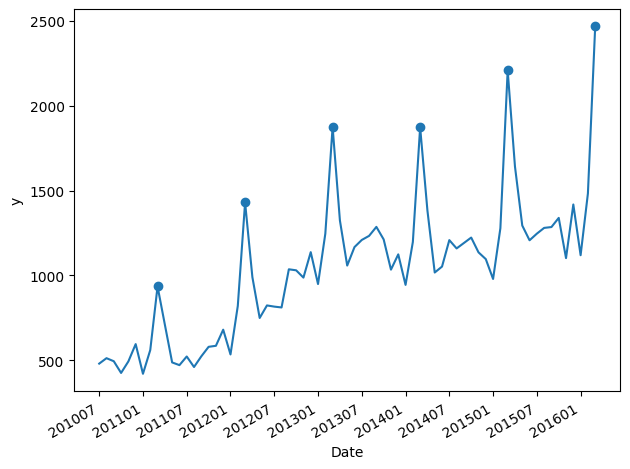

In [40]:
# ピーク位置を確認
fig, ax = plt.subplots()

ax.plot(df['year_month'], df['y'], markevery=np.arange(8, 69, 12), marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('y')

plt.xticks(
    np.arange(0, 68, 6),  # 目盛りの位置: 0から69まで6刻み
    ["201007", "201101", "201107", "201201", "201207", "201301", "201307", "201401", "201407", "201501", "201507", "201601"]  # ラベル: 合計13個
)

fig.autofmt_xdate()
plt.tight_layout()

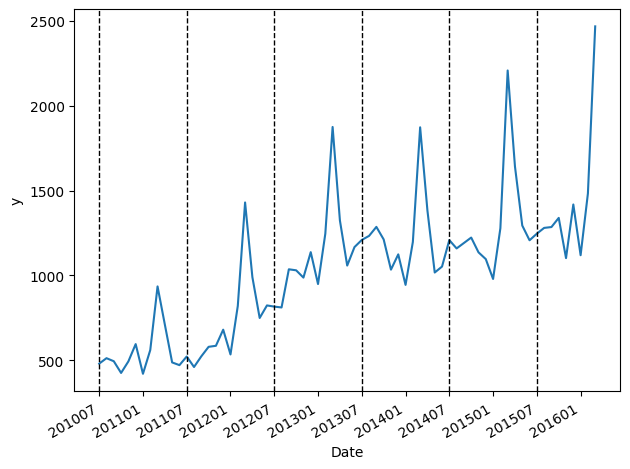

In [42]:
# 12ヶ月周期のデータ確認
fig, ax = plt.subplots()

ax.plot(df['year_month'], df['y'])
for i in np.arange(0, 69, 12):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('y')

plt.xticks(
    np.arange(0, 68, 6),  # 目盛りの位置: 0から69まで6刻み
    ["201007", "201101", "201107", "201201", "201207", "201301", "201307", "201401", "201407", "201501", "201507", "201601"]  # ラベル: 合計13個
)

fig.autofmt_xdate()
plt.tight_layout()

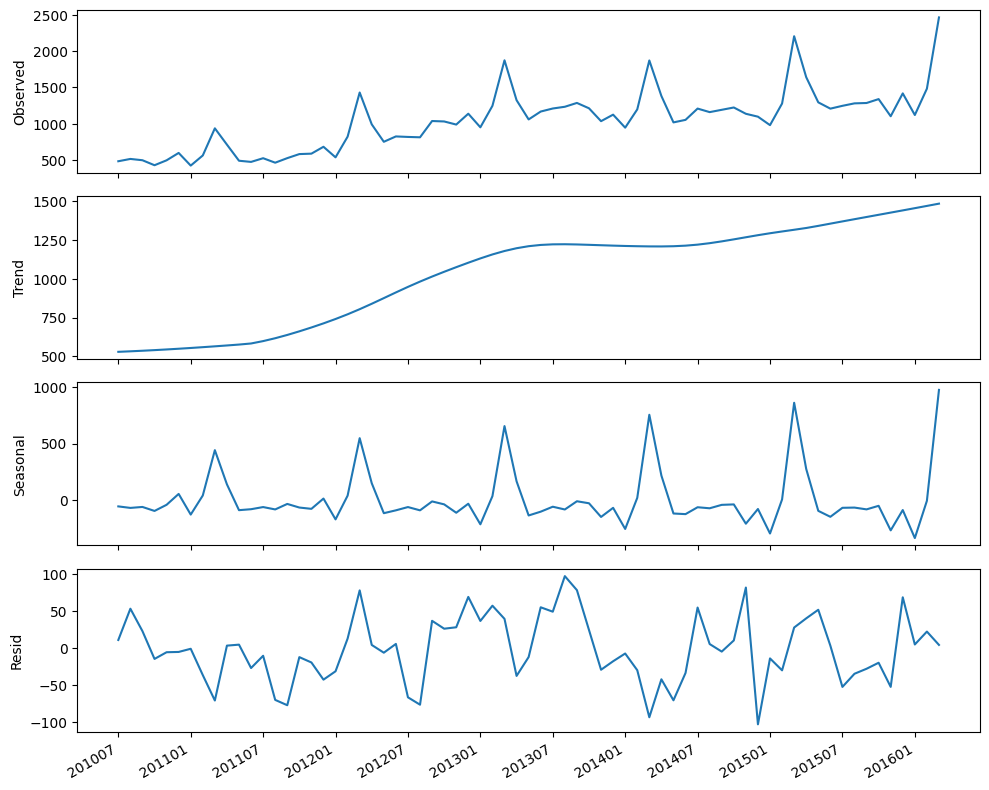

In [43]:
from statsmodels.tsa.seasonal import STL

# STL関数を使って時系列分解
# 期間は頻度mに等しい：日時データを使うので期間はm=12となる
decomposition = STL(y_yearmonth["y"], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 8))

#生データ
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
#トレンド
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
#季節性
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
#残差
ax4.plot(decomposition.resid)
ax4.set_ylabel('Resid')

# グラフ表示
plt.xticks(
    np.arange(0, 72, 6),  # 目盛りの位置: 0から72まで6刻み
    ["201007", "201101", "201107", "201201", "201207", "201301", "201307", "201401", "201407", "201501", "201507", "201601"]  # ラベル: 合計13個
)

fig.autofmt_xdate()
plt.tight_layout()

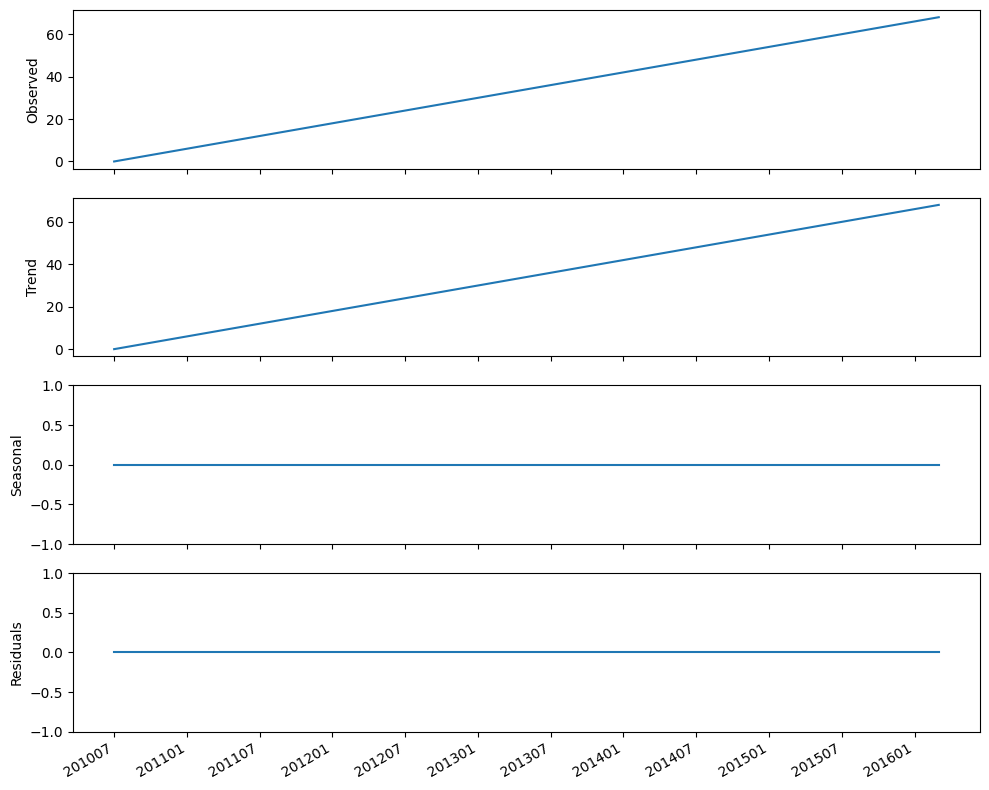

In [45]:
linear_ts = np.arange(0, 69, 1)

decomposition = STL(linear_ts, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_ylim(-1, 1)

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
ax4.set_ylim(-1, 1)

plt.xticks(
    np.arange(0, 72, 6),  # 目盛りの位置: 0から72まで6刻み
    ["201007", "201101", "201107", "201201", "201207", "201301", "201307", "201401", "201407", "201501", "201507", "201601"]  # ラベル: 合計13個
)

fig.autofmt_xdate()
plt.tight_layout()

In [46]:
# ADF検定
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(y_yearmonth["y"])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.416167163384358
p-value: 0.5745013063083023


In [47]:
# 1次差分
df_diff = np.diff(y_yearmonth["y"], n=1)

ad_fuller_result = adfuller(df_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.9748687407233327
p-value: 0.2976998087384047


In [48]:
# 季節性のADF検定
df_diff_seasonal_diff = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.937019446700395
p-value: 1.0482864685025592e-09


In [49]:
# 2次差分
df_diff2 = np.diff(df_diff, n=1)

ad_fuller_result = adfuller(df_diff2)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -7.01971299838769
p-value: 6.591406971881708e-10


In [52]:
# fig, ax = plt.subplots()

# ax.plot(df['year_month'][13:], eps_diff_seasonal_diff)
# ax.set_xlabel('Date')
# ax.set_ylabel('y - diff')

# plt.xticks(
#     np.arange(0, 72, 6),  # 目盛りの位置: 0から72まで6刻み
#     ["201007", "201101", "201107", "201201", "201207", "201301", "201307", "201401", "201407", "201501", "201507", "201601"]  # ラベル: 合計13個
# )

# fig.autofmt_xdate()
# plt.tight_layout()

In [12]:
# from statsmodels.tsa.seasonal import STL

# # STL関数を使って時系列分解
# # 期間は頻度mに等しい：日時データを使うので期間はm=365となる
# decomposition = STL(df_train["y"], period=365).fit()

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 8))

# #生データ
# ax1.plot(decomposition.observed)
# ax1.set_ylabel('Observed')
# #トレンド
# ax2.plot(decomposition.trend)
# ax2.set_ylabel('Trend')
# #季節性
# ax3.plot(decomposition.seasonal)
# ax3.set_ylabel('Seasonal')
# #残差
# ax4.plot(decomposition.resid)
# ax4.set_ylabel('Resid')

# # グラフ表示
# plt.xticks(np.arange(0, 2101, 12), np.arange(2010, 2016, 1))

# fig.autofmt_xdate()
# plt.tight_layout()

In [17]:
# def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

#     results = []

#     for order in tqdm_notebook(order_list):
#         try:
#             model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
#         except:
#             continue

#         aic = model.aic
#         results.append([order, aic])

#     result_df = pd.DataFrame(results)
#     result_df.columns = ['(p,q)', 'AIC']

#     #Sort in ascending order, lower AIC is better
#     result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

#     return result_df

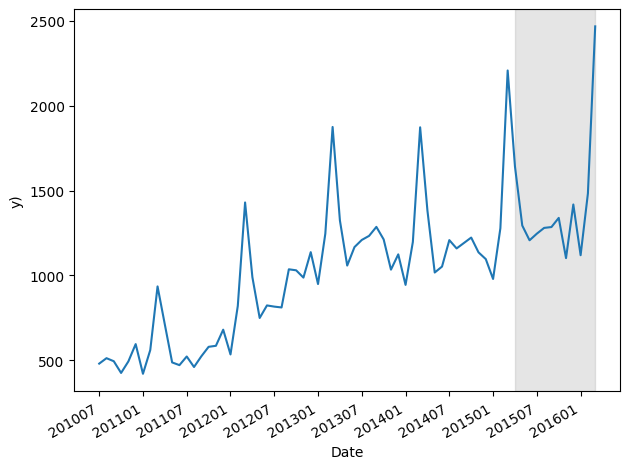

In [57]:
fig, ax = plt.subplots()

ax.plot(df['year_month'], df['y'])
ax.set_xlabel('Date')
ax.set_ylabel('y)')
ax.axvspan(57, 68, color='#808080', alpha=0.2)

plt.xticks(
    np.arange(0, 72, 6),  # 目盛りの位置: 0から72まで6刻み
    ["201007", "201101", "201107", "201201", "201207", "201301", "201307", "201401", "201407", "201501", "201507", "201601"]  # ラベル: 合計13個
)

fig.autofmt_xdate()
plt.tight_layout()

In [58]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [60]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [61]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

d = 2
D = 0
s = 12

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['y'][:-12]

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(11, 0, 0, 0)",702.771933
1,"(12, 3, 0, 0)",703.174125
2,"(11, 2, 0, 0)",703.871449
3,"(12, 4, 0, 0)",704.472957
4,"(12, 0, 0, 0)",704.501538
5,"(11, 1, 0, 0)",705.057539
6,"(11, 3, 0, 0)",705.613399
7,"(12, 5, 0, 0)",705.670002
8,"(12, 1, 0, 0)",705.812636
9,"(11, 6, 0, 0)",706.701706


In [62]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['y'][:-12]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(0, 0, 3, 0)",527.896914
1,"(0, 1, 3, 0)",528.711315
2,"(1, 0, 3, 0)",529.173971
3,"(3, 2, 3, 0)",529.208236
4,"(2, 0, 3, 0)",529.472203
5,"(0, 2, 3, 0)",529.658534
6,"(0, 0, 3, 1)",529.884194
7,"(0, 1, 3, 1)",530.695531
8,"(1, 3, 3, 0)",530.918574
9,"(0, 0, 0, 3)",530.999588


In [63]:
ARIMA_model = SARIMAX(train, order=(11,2,0), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   57
Model:              SARIMAX(11, 2, 0)   Log Likelihood                -339.386
Date:                Sat, 07 Sep 2024   AIC                            702.772
Time:                        09:39:57   BIC                            726.860
Sample:                             0   HQIC                           712.087
                                 - 57                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9603      0.076    -12.624      0.000      -1.109      -0.811
ar.L2         -1.0241      0.078    -13.080      0.000      -1.178      -0.871
ar.L3         -0.9217      0.104     -8.854      0.0

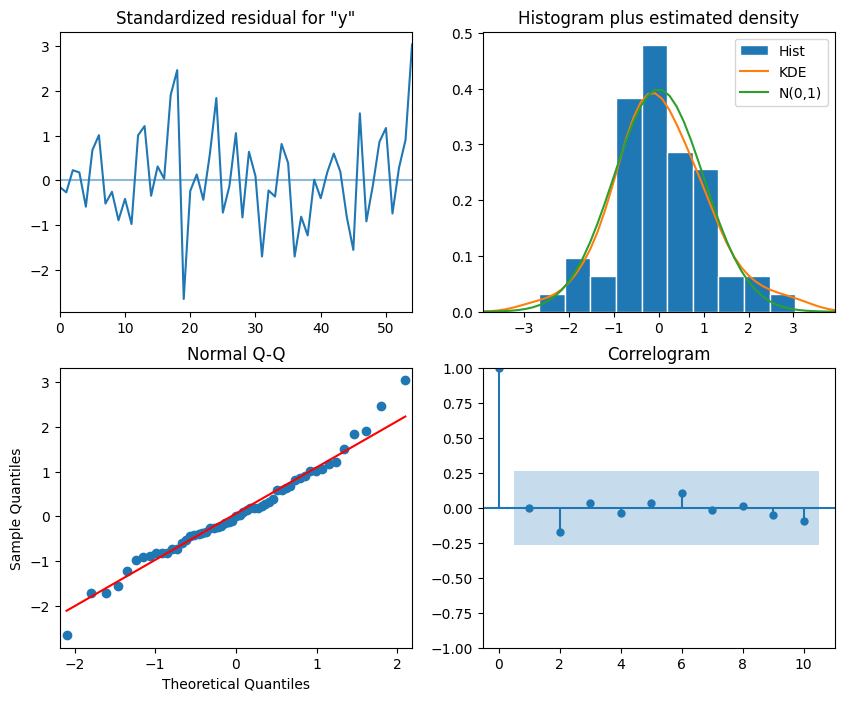

In [64]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [69]:
residuals = ARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [68]:
test = df.iloc[-12:]

test['naive_seasonal'] = df['y'].iloc[57:69].values
test

,year_month,y,naive_seasonal
57,201504,1642,1642
58,201505,1294,1294
59,201506,1207,1207
60,201507,1246,1246
61,201508,1280,1280
62,201509,1285,1285
63,201510,1339,1339
64,201511,1102,1102
65,201512,1418,1418
66,201601,1119,1119


In [71]:
ARIMA_pred = ARIMA_model_fit.get_prediction(57, 69).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,year_month,y,naive_seasonal,ARIMA_pred
57,201504,1642,1642,1769.450311
58,201505,1294,1294,1386.662972
59,201506,1207,1207,1513.016902
60,201507,1246,1246,1653.601773
61,201508,1280,1280,1615.877757
62,201509,1285,1285,1668.651161
63,201510,1339,1339,1718.639106
64,201511,1102,1102,1624.430486
65,201512,1418,1418,1515.620862
66,201601,1119,1119,1424.206845


In [74]:
SARIMA_model = SARIMAX(train, order=(0,1,0), seasonal_order=(3,1,0,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   57
Model:             SARIMAX(0, 1, 0)x(3, 1, 0, 12)   Log Likelihood                -259.948
Date:                            Sat, 07 Sep 2024   AIC                            527.897
Time:                                    09:52:29   BIC                            535.034
Sample:                                         0   HQIC                           530.544
                                             - 57                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2330      0.226      1.029      0.303      -0.211       0.677
ar.S.L24      -0.3006      0.251   

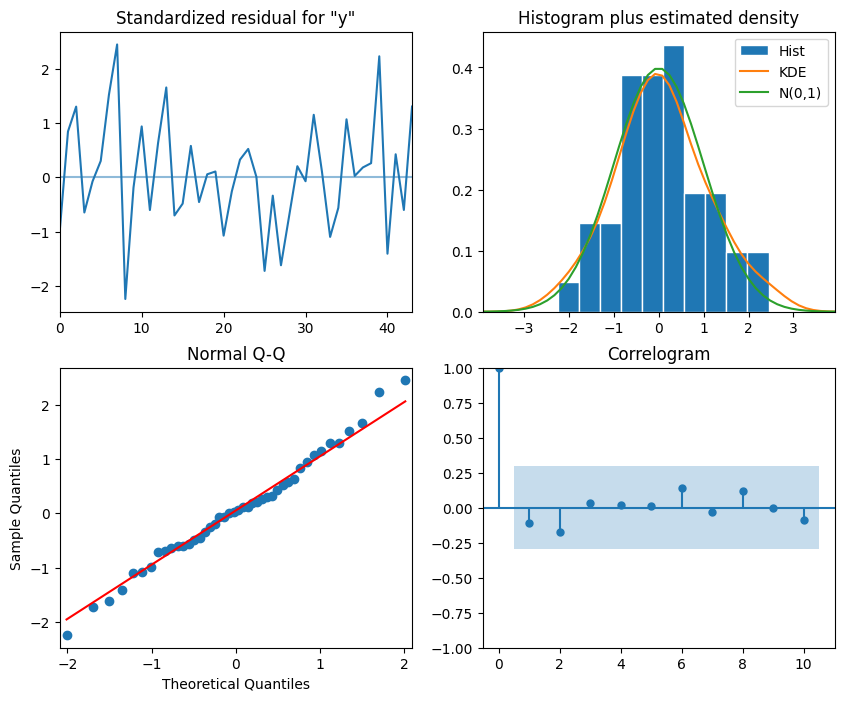

In [75]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [76]:
residuals = SARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [78]:
SARIMA_pred = SARIMA_model_fit.get_prediction(57, 69).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,year_month,y,naive_seasonal,ARIMA_pred,SARIMA_pred
57,201504,1642,1642,1769.450311,1617.116710
58,201505,1294,1294,1386.662972,1224.234350
59,201506,1207,1207,1513.016902,1293.100552
60,201507,1246,1246,1653.601773,1421.218765
61,201508,1280,1280,1615.877757,1385.523079
62,201509,1285,1285,1668.651161,1575.272050
63,201510,1339,1339,1718.639106,1609.957727
64,201511,1102,1102,1624.430486,1551.190924
65,201512,1418,1418,1515.620862,1536.596319
66,201601,1119,1119,1424.206845,1403.111217


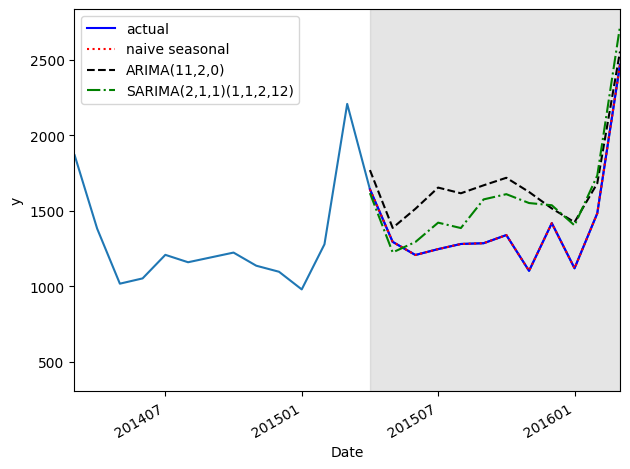

In [79]:
fig, ax = plt.subplots()

ax.plot(df['year_month'], df['y'])
ax.plot(test['y'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,0)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('y')
ax.axvspan(57, 68, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(
    np.arange(0, 72, 6),  # 目盛りの位置: 0から72まで6刻み
    ["201007", "201101", "201107", "201201", "201207", "201301", "201307", "201401", "201407", "201501", "201507", "201601"]  # ラベル: 合計13個
)
ax.set_xlim(44, 68)

fig.autofmt_xdate()
plt.tight_layout()

In [83]:
# MAPEで評価

def mape(y_true, y_pred):
    # 0除算を避けるため、0を除外したy_trueを使用
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_idx = y_true != 0
    y_true = y_true[non_zero_idx]
    y_pred = y_pred[non_zero_idx]

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_naive_seasonal = mape(test['y'], test['naive_seasonal'])
mape_ARIMA = mape(test['y'], test['ARIMA_pred'])
mape_SARIMA = mape(test['y'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA, mape_SARIMA)

0.0 21.32802504026411 15.071871677648124


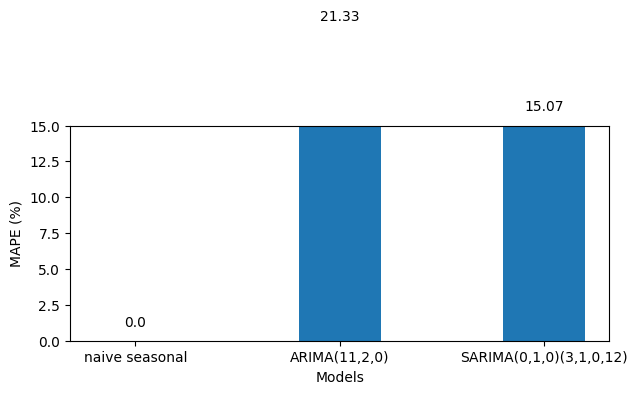

In [85]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(11,2,0)', 'SARIMA(0,1,0)(3,1,0,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

In [59]:
# # 最適なSARIMAモデルを選択する関数
# from typing import Union
# from tqdm import tqdm_notebook
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # order_listパラメータに字数p,q,P,Qが含まれるようになった
# # 季節差分の次数Dと頻度sも追加する
# # SARIMAモデルの頻度mはstatsmodelsライブラリの実装ではsであることに注意

# def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

#     results = []

#     # 一意なARIMA(p,d,q)(P,D,Q)_mモデルをすべてループ処理し、それぞれのモデルに適合させ、AICの値を格納
#     for order in tqdm_notebook(order_list):
#         try:
#             model = SARIMAX(
#                 endog,
#                 order=(order[0], d, order[1]),
#                 seasonal_order=(order[2], D, order[3], s),
#                 simple_differencing=False).fit(disp=False)
#         except:
#             continue

#         aic = model.aic
#         results.append([order, aic])

#     result_df = pd.DataFrame(results)
#     result_df.columns = ['(p,q,P,Q)', 'AIC']

#     # 昇順でソート：AICの値が小さいほどよいモデルである
#     result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

#     # AICの値の昇順でソートされたDataFrameを返す
#     return result_df

In [19]:
# # ARIMA(p,d,q)モデルで予測
# from itertools import product

# # 季節情報を組み込むためにpとqの値の範囲を0~12に設定
# ps = range(0, 13, 1)
# qs = range(0, 13, 1)

# # ARIMA(p,d,q)モデルを使っているのでPとQの値を0に設定
# Ps = [0]
# Qs = [0]

# # 時系列を定常化するために差分を取った回数をdの値として設定
# # ARIMA(p,d,q)モデルを使っているのでDの値を0に設定
# # statsmodelsライブラリのパラメータsはmに相当し、どちらも頻度を表す
# d = 2
# D = 0
# s = 12

# # (p,d,q)(0,0,0)の組み合わせとして考えられるものをすべて生成
# ARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [20]:
# # 最後の年は評価データとして用いる
# train = y_yearmonth["y"][:-12]

# # optimize_SARIMA関数を実行
# ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
# # AICの昇順でソートされたDataFrameを表示
# ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(11, 0, 0, 0)",702.771933
1,"(12, 3, 0, 0)",703.174125
2,"(11, 2, 0, 0)",703.871449
3,"(12, 4, 0, 0)",704.472957
4,"(12, 0, 0, 0)",704.501538
5,"(11, 1, 0, 0)",705.057539
6,"(11, 3, 0, 0)",705.613399
7,"(12, 5, 0, 0)",705.670002
8,"(12, 1, 0, 0)",705.812636
9,"(11, 6, 0, 0)",706.701706


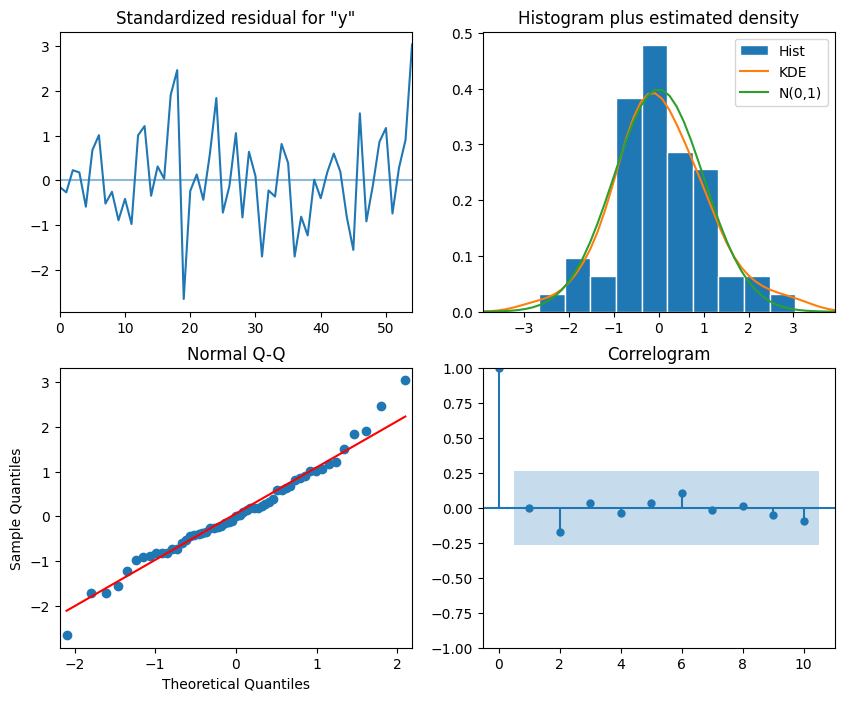

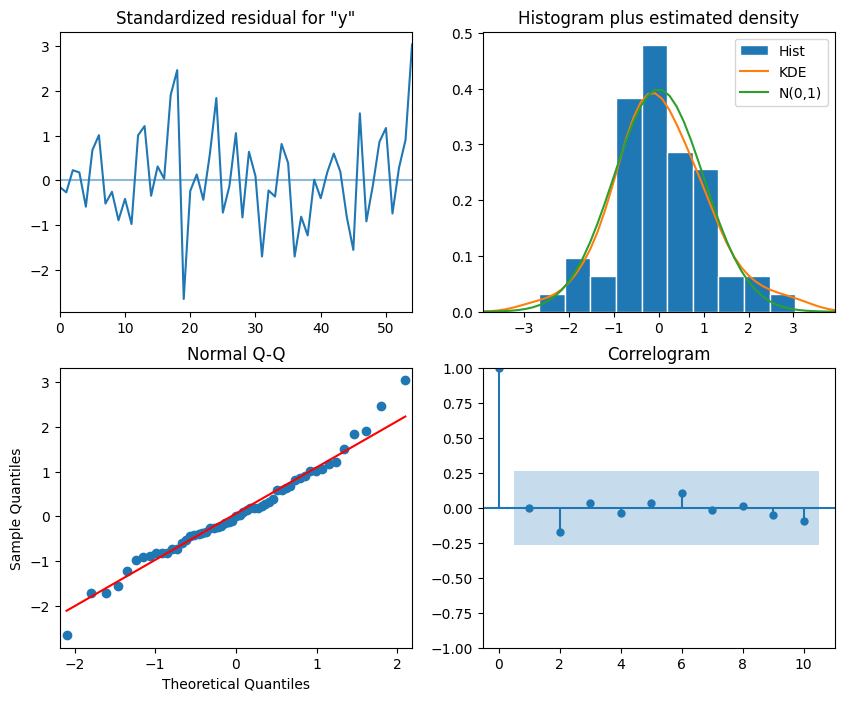

In [21]:
# ARIMA_model = SARIMAX(train, order=(11, 2, 0), simple_differencing=False)
# ARIMA_model_fit = ARIMA_model.fit(disp=False)

# ARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [22]:
# # リュング・ボックス検定を実行
# from statsmodels.stats.diagnostic import acorr_ljungbox

# residuals = ARIMA_model_fit.resid
# result_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
# result_df

,lb_stat,lb_pvalue
1,0.376505,0.539480
2,1.742050,0.418522
3,1.906342,0.592071
4,2.014729,0.733050
5,2.051685,0.841948
6,2.514561,0.866835
7,2.694804,0.911728
8,4.168478,0.841612
9,4.679650,0.861292
10,4.682358,0.911362


In [ ]:
# test = df[-12:]

# test["naive_seasonal"] = y_yearmonth.iloc[57:68].values

In [ ]:
# ARIMA_pred = ARIMA_model_fit.get_prediction(57, 68)

In [ ]:
# # ADF検定
# from statsmodels.tsa.stattools import adfuller

# ad_fuller_result = adfuller(df_train["y"])
# print(f'ADF Statistic: {ad_fuller_result[0]}')
# print(f'p-value: {ad_fuller_result[1]}')

ADF統計量は-1.4、p値は0.57 ⇨ 帰無仮説を棄却することはできないため、定常ではない

In [ ]:
# # 1次差分
# df_diff = np.diff(df_train["y"], n=1)

# ad_fuller_result = adfuller(df_diff)
# print(f'ADF Statistic: {ad_fuller_result[0]}')
# print(f'p-value: {ad_fuller_result[1]}')

ADF統計量は-15.9、p値は8.11*10^(-29) ⇨ 差分1回で帰無仮説を棄却することができた。

時系列データを定常化するために差分を1回取ったので、d=1となる。

In [ ]:
# # ARIMA(p,d,q)モデルで予測
# from itertools import product

# # 季節情報を組み込むためにpとqの値の範囲を0~365に設定
# ps = range(0, 366, 1)
# qs = range(0, 366, 1)

# # ARIMA(p,d,q)モデルを使っているのでPとQの値を0に設定
# Ps = [0]
# Qs = [0]

# # 時系列を定常化するために差分を取った回数をdの値として設定
# # ARIMA(p,d,q)モデルを使っているのでDの値を0に設定
# # statsmodelsライブラリのパラメータsはmに相当し、どちらも頻度を表す
# d = 1
# D = 0
# s = 365

# # (p,d,q)(0,0,0)の組み合わせとして考えられるものをすべて生成
# ARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [ ]:
# # 最適なSARIMAモデルを選択する関数
# from typing import Union
# from tqdm import tqdm_notebook
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # order_listパラメータに字数p,q,P,Qが含まれるようになった
# # 季節差分の次数Dと頻度sも追加する
# # SARIMAモデルの頻度mはstatsmodelsライブラリの実装ではsであることに注意

# def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list,
#                     d: int, D: int, s: int) -> pd.DataFrame:
#     results = []

#     # 一意なARIMA(p,d,q)(P,D,Q)_mモデルをすべてループ処理し、それぞれのモデルに適合させ、AICの値を格納
#     for order in tqdm_notebook(order_list):
#       try:
#         model = SARIMAX(endog,
#                         order=(order[0], d, order[1]),
#                         seasonal_order=(order[2], D, order[3], s),
#                         simple_differencing=False).fit(disp=False)
#       except:
#         continue

#       aic = model.aic
#       results.append([order, aic])

#     # 昇順でソート：AICの値が小さいほどよいモデルである
#     result_df = result_df.sort_values(
#         by='AIC', ascending=True).reset_index(drop=True)

#     # AICの値の昇順でソートされたDataFrameを返す
#     return result_df

In [ ]:
# # 最後の年は評価データとして用いる
# train = df_train["y"][:-365]

# # optimize_SARIMA関数を実行
# ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
# # AICの昇順でソートされたDataFrameを表示
# ARIMA_result_df

In [ ]:
ARIMA_model = SARIMAX(train, order=(11, 2, 3), simple_diierencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

ARIMA_model_fit.plot_diagnostics(figsize=(10,8))

# Submission

In [ ]:
# test = pd.read_csv('/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/test.csv')
# test.shape

In [ ]:
# X_test = test[features]
# X_test.shape

In [ ]:
# y_test_pred = model.predict(X_test)

# df_submit = pd.DataFrame({
#     'datetime': test["datetime"],
#     'y': y_test_pred
# })

# df_submit.head()

In [ ]:
# df_submit.to_csv("submission1.csv", index=False, header=False)